# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


**(1) For each of the first 5 training examples, print the text of the message along with the label.**

In [9]:
def P1(num_examples=5):
### STUDENT START ###
    # start and end to format header as bold and red
    start = "\x1b[1;31m"
    end = "\x1b[0m"
    i = 1
    
    # loop over training data and training labels to
    print "_" * 80
    for i in range(num_examples):
        # print label name from newsgroups_train.target_names
        print(start + "Example #" + str(i+1) + " - Label = '" + newsgroups_train.target_names[train_labels[i]] + "' :" + end)
        # print message text
        print train_data[i]
        print "_" * 80

### STUDENT END ###
P1(5)


________________________________________________________________________________
Example #1 - Label = 'comp.graphics' :
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
________________________________________________________________________________
Example #2 - Label = 'talk.religion.misc' :


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch o

**(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").**

**The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:**

**a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.**

**b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.**

**c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?**

**d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?**

**e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?**

**f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.**

In [11]:
def P2():   
### STUDENT START ###
    # [ a ] . output of transform
    print "_" * 80
    print "a. initialize CountVectorizer to tokenize and count unigram-word occurrences in documents\n"
    # countvectorizer tokenizes and count the word occurrences of text documents
    # with default parameters vectorizer creates a column for every possible word
    # in the text
    count_vectorizer = CountVectorizer()
    # feature extraction by turning raw training text to feature vectors
    train_x = count_vectorizer.fit_transform(train_data)

    vocab_size = len(count_vectorizer.vocabulary_)
    total_nonzero = float(train_x.nnz)
    total_examples = train_x.shape[0]

    print "size of the vocabulary = %d" % ( vocab_size )
    print "total non-zero features in the matrix = %d" % ( total_nonzero )
    print "average number of non-zero features per example = %2.2f" % ( total_nonzero/total_examples )
    print "sparsity (fraction of non-zero entries in the matrix) = %.2f%%" % (100.0 * total_nonzero / (total_examples * vocab_size))
      
    # [ b ] . get feature names
    print "_" * 80
    print "b . get first and last feature names\n"
    print "0th  feature string = %s" % ( count_vectorizer.get_feature_names()[0] )
    print "last feature string = %s" % ( count_vectorizer.get_feature_names()[vocab_size-1] )

    # [ c ] . defining own vocabulary as feature indices
    print "_" * 80
    print "c . defining own vocabulary as feature indices"
    print "    vocabulary = ['atheism', 'graphics', 'space', 'religion']\n"
    vocab = ["atheism", "graphics", "space", "religion"]
    
    # tokenizing and counting the word occurrences with new vocabulary
    count_vectorizer_vocab = CountVectorizer(vocabulary = vocab)
    # feature extraction by turning raw training text to feature vectors
    train_x_vocab = count_vectorizer_vocab.fit_transform(train_data)

    total_nonzero = float(train_x_vocab.nnz)
    total_examples = float(train_x_vocab.shape[0])
    
    print "confirming the training vectors shape = " +  str(train_x_vocab.shape)
    print "note: length of feature vector for each text is 4 as new vocabulary length is 4\n"
    print "average number of non-zero features per example = %2.3f" % ( total_nonzero/total_examples )

    # [ d ] . extract bigram and trigram character features
    print "_" * 80
    print "d. extract bigram and trigram character features\n"
    # tokenizing and counting the 2-char and 3-char grams
    bitrigram_vectorizer = CountVectorizer(analyzer="char", ngram_range = (2,3))
    # feature extraction by turning raw training text to feature vectors
    train_x_bitrigram = bitrigram_vectorizer.fit_transform(train_data)

    print "size of the vocabulary with bi-gram and tri-gram characters = %d" % ( len(bitrigram_vectorizer.vocabulary_) )

    # [ e ] . prune words that appear in fewer than 10 documents
    print "_" * 80
    print "e. prune words that appear in fewer than 10 documents\n"
    # tokenizing and counting word occurences that appear in more than 10 documents
    min_df_vectorizer = CountVectorizer(min_df = 10)
    # feature extraction by turning raw training text to feature vectors
    train_x_min_df = min_df_vectorizer.fit_transform(train_data)

    print "size of the vocabulary with min_df:10 = %d" % ( len(min_df_vectorizer.vocabulary_) )    

    # [ f ]. fraction of the words in the dev data are missing from the vocabulary
    print "_" * 80
    print "f. fraction of the words in the dev data are missing from the vocabulary\n"
    # tokenize and count word occurences in dev data set
    count_all_vectorizer = CountVectorizer()
    # feature extraction by turning raw training text to feature vectors
    dev_x = count_all_vectorizer.fit_transform(dev_data)
    # get vocabulary size for dev data only
    vocab_dev_sz = len(count_all_vectorizer.vocabulary_)
    vocab_dev = count_all_vectorizer.vocabulary_.keys()
    print "size of dev data vocabulary = %d" % ( vocab_dev_sz )

    # feature extraction from both training and dev data set
    train_x = count_all_vectorizer.fit_transform(train_data)
    # get vocabulary size for training and dev data only
    vocab_trn_sz = len(count_all_vectorizer.vocabulary_)
    vocab_trn = count_all_vectorizer.vocabulary_.keys()
    print "size of training data vocabulary = %d" % ( vocab_trn_sz )

    # common vocabulary size
    vocab_common_sz = len(set(vocab_trn).intersection(vocab_dev))
    print "size of common vocabulary = %d" % ( vocab_common_sz )
    
    # fraction of missing words from dev
    print "fraction of missing words from dev data = %.2f%%" % (100.0 * (1 - (vocab_common_sz/float(vocab_dev_sz))))
    print "_" * 80
### STUDENT END ###

P2()

________________________________________________________________________________
a. initialize CountVectorizer to tokenize and count unigram-word occurrences in documents

size of the vocabulary = 26879
total non-zero features in the matrix = 196700
average number of non-zero features per example = 96.71
sparsity (fraction of non-zero entries in the matrix) = 0.36%
________________________________________________________________________________
b . get first and last feature names

0th  feature string = 00
last feature string = zyxel
________________________________________________________________________________
c . defining own vocabulary as feature indices
    vocabulary = ['atheism', 'graphics', 'space', 'religion']

confirming the training vectors shape = (2034, 4)
note: length of feature vector for each text is 4 as new vocabulary length is 4

average number of non-zero features per example = 0.268
________________________________________________________________________________
d

**(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:**

**a. Why doesn't nearest neighbors work well for this problem?**

**b. Any ideas why logistic regression doesn't work as well as Naive Bayes?**

**c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.**

________________________________________________________________________________
a. k Nearest Neighbors Classifier

Training data (transformed) shape : (2034, 26879)
Training labels bin count : 
                   alt.atheism 480
                 comp.graphics 584
                     sci.space 593
            talk.religion.misc 377


Plotting grid search results for kNN classifier


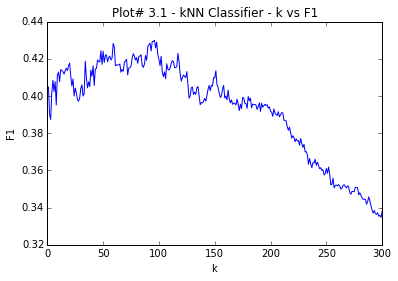

Optimal value for k
k = 96 has best F1 score = 0.429990


Predicting text classification for the transformed dev data

Classification Report
                    precision    recall  f1-score   support

       alt.atheism       0.47      0.32      0.38       165
     comp.graphics       0.48      0.59      0.53       185
         sci.space       0.48      0.57      0.52       199
talk.religion.misc       0.34      0.27      0.30       127

       avg / total       0.45      0.46      0.45       676

F1 score for a k nearest neighbors classifier on dev data is 0.448345 with k = 96
________________________________________________________________________________
b. Multinomial Naive Bayes Classifier

Plotting grid search results for Multinomial Naive Bayes classifier


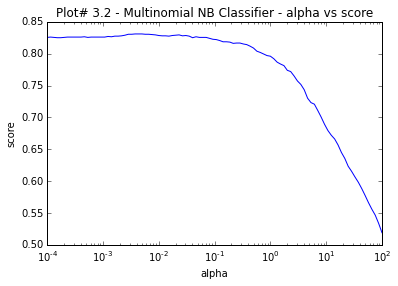

Optimal value for alpha
alpha = 0.003765 has the best score = 0.830875

Predicting text classification for the transformed dev data

Classification Report
                    precision    recall  f1-score   support

       alt.atheism       0.67      0.70      0.68       165
     comp.graphics       0.92      0.90      0.91       185
         sci.space       0.80      0.90      0.85       199
talk.religion.misc       0.64      0.51      0.57       127

       avg / total       0.77      0.78      0.77       676

score for a Multinomial Naive Bayes classifier on dev data is 0.772391 with alpha = 0.003765
________________________________________________________________________________
c. Logistic Regression Model

Plotting grid search results for Logistic Regression Model


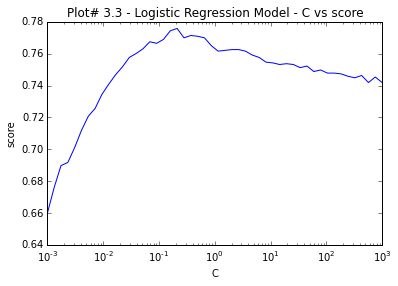

Optimal value for C
C = 0.212095 has the best score = 0.775811

Predicting text classification for the transformed dev data

Classification Report
                    precision    recall  f1-score   support

       alt.atheism       0.62      0.55      0.59       165
     comp.graphics       0.80      0.89      0.84       185
         sci.space       0.75      0.82      0.79       199
talk.religion.misc       0.58      0.50      0.54       127

       avg / total       0.70      0.71      0.71       676

score for a Logistic Regression Model on dev data is 0.705873 with C = 0.212095
________________________________________________________________________________
Relationship between sum of the squared weight values for each class and C parameter on training data

         C | Sum of squared coefficients for each class
     0.001 |    0.16509 |    0.20095 |    0.18067 |    0.18724
   0.00133 |    0.23386 |    0.28907 |    0.25917 |     0.2572
   0.00176 |    0.32987 |    0.41127 |    0.

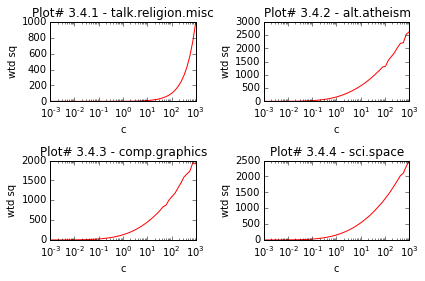

In [13]:
def P3():
### STUDENT START ###
# WARNING: due to longer range of search parameter (C, alpha, k) this functions runs ~5 min

    # DEFINE SUB-FUNCTIONS
    # k Nearest Neighbors Classifier
    def knn(train_x, dev_x):
        # k nearest neighbors classifier
        print "_" * 80
        print "a. k Nearest Neighbors Classifier\n"
        print "Training data (transformed) shape : %s" % ( str(train_x.shape) )
        print "Training labels bin count : "
        for (label, count) in np.asarray((np.unique(train_labels, return_counts=True))).T:
            print "%30s %s" % ( newsgroups_train.target_names[label], str(count))
        print "\n"
        # initialize knn classifier
        knn = KNeighborsClassifier(p=2, metric='minkowski')

        # define k-neighbors range from 1 to 300 with step of 1 this brute force approach is to find optimal k 
        k_range = np.arange(1, 301, 1)
        param_grid = dict(n_neighbors = k_range)

        # use GridSearch to run cross validations and find optimal parameters optimum value will be decided 
        # based on best F1 score i.e. weighted average of precision and recall
        grid = GridSearchCV(knn, param_grid, cv = 3, scoring = 'f1')
        grid.fit(train_x, train_labels)

        # plot the results of the grid search
        grid_mean_scores = [result[1] for result in grid.grid_scores_]  

        print "Plotting grid search results for kNN classifier"
        fig, ax = plt.subplots(1, 1)
        ax.set_title('Plot# 3.1 - kNN Classifier - k vs F1')
        ax.set_ylabel('F1')
        ax.set_xlabel('k')
        ax.plot(k_range, grid_mean_scores)
        plt.show()

        # fit model with optimium k
        k = grid.best_params_['n_neighbors']
        print "Optimal value for k"
        print "k = %d has best F1 score = %f" % (k, grid.best_score_)
        print "\n"

        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', metric_params=None, p=2)
        knn.fit(train_x, train_labels)

        # Predict dev labels
        print "Predicting text classification for the transformed dev data\n"
        dev_predictions = knn.predict(dev_x)

        # Classification Report
        print "Classification Report"
        print classification_report(dev_labels, dev_predictions, target_names=newsgroups_train.target_names)
        print "F1 score for a k nearest neighbors classifier on dev data is %f with k = %d" % ( metrics.f1_score(dev_labels, dev_predictions), k )

    def mnb(train_x, dev_x):
        # multinomial naive bayes classifier
        print "_" * 80
        print "b. Multinomial Naive Bayes Classifier\n"
        # initialize  Multinomial Naive Bayes classifier
        mnb = MultinomialNB()

        # define parameter grid
        alpha_range = np.logspace(-4., 2., 100)
        param_grid = dict(alpha = alpha_range)

        # use GridSearch to run cross validations and find optimal parameters
        # optimum value will be decided based on the score
        grid = GridSearchCV(mnb, param_grid)
        grid.fit(train_x, train_labels)

        # plot the results of the grid search
        grid_mean_scores = [result[1] for result in grid.grid_scores_]  

        print "Plotting grid search results for Multinomial Naive Bayes classifier"
        fig, ax = plt.subplots(1, 1)
        ax.set_title("Plot# 3.2 - Multinomial NB Classifier - alpha vs score")
        ax.set_xlabel("alpha")
        ax.set_xscale("log")
        ax.set_ylabel("score")
        ax.plot(alpha_range, grid_mean_scores)
        plt.show()
        
        # fit model with optimium alpha
        alpha = grid.best_params_['alpha']
        print "Optimal value for alpha"
        print "alpha = %f has the best score = %f\n" % (alpha, grid.best_score_)

        mnb = MultinomialNB(alpha=alpha)
        mnb.fit(train_x, train_labels)

        # Predict dev labels
        print "Predicting text classification for the transformed dev data\n"
        dev_predictions = mnb.predict(dev_x)

        # Classification Report
        print "Classification Report"
        print classification_report(dev_labels, dev_predictions, target_names=newsgroups_train.target_names)
        print "score for a Multinomial Naive Bayes classifier on dev data is %f with alpha = %f" % ( metrics.f1_score(dev_labels, dev_predictions), alpha )

    def lgr(train_x, dev_x):
        # Logistic Regression Model
        print "_" * 80
        print "c. Logistic Regression Model\n"
        # initialize Logistic Regression Model
        lgr = LogisticRegression(penalty='l2')

        # define parameter grid
        c_range = np.logspace(-3., 3., 50)
        param_grid = dict(C = c_range)

        # use GridSearch to run cross validations and find optimal parameters
        # optimum value will be decided based on the score
        grid = GridSearchCV(lgr, param_grid)
        grid.fit(train_x, train_labels)

        # plot the results of the grid search
        grid_mean_scores = [result[1] for result in grid.grid_scores_]  
        
        print "Plotting grid search results for Logistic Regression Model"
        fig, ax = plt.subplots(1, 1)
        ax.set_title("Plot# 3.3 - Logistic Regression Model - C vs score")
        ax.set_xscale("log")
        ax.set_ylabel("score")
        ax.set_xlabel("C")
        ax.plot(c_range, grid_mean_scores)
        plt.show()
        
        # fit model with optimium alpha
        C = grid.best_params_['C']
        print "Optimal value for C"
        print "C = %f has the best score = %f\n" % (C, grid.best_score_)

        lgr = LogisticRegression(C=C, penalty='l2')
        lgr.fit(train_x, train_labels)

        # Predict dev labels
        print "Predicting text classification for the transformed dev data\n"
        dev_predictions = lgr.predict(dev_x)

        # Classification Report
        print "Classification Report"
        print classification_report(dev_labels, dev_predictions, target_names=newsgroups_train.target_names)
        print "score for a Logistic Regression Model on dev data is %f with C = %f" % ( metrics.f1_score(dev_labels, dev_predictions), C )

        print "_" * 80
        print "Relationship between sum of the squared weight values for each class and C parameter on training data\n"
        print "%10s | %s" % ("C", "Sum of squared coefficients for each class")

        # run logistic regression for each setting of C and append sum of squares of weights
        # for each C and class to an array
        lgr_coef = []
        for c in c_range:
            lgr = LogisticRegression(C=c, penalty='l2') 
            lgr.fit(train_x, train_labels)

            sq_coef = []
            sq_coef.append(c)
            [sq_coef.append(np.sum(np.power(lgr.coef_[x], 2))) for x in range(0,4)]

            lgr_coef.append(sq_coef)
            print "%10s | %10s | %10s | %10s | %10s" % (round(c, 5), round(sq_coef[1],5), round(sq_coef[2],5), round(sq_coef[3],5), round(sq_coef[4],5))

        np_coef = np.asarray(lgr_coef, dtype = "object")

    
        # plot relationship between C and sum of the squared weight
        fig, axes = plt.subplots(nrows=2, ncols=2)
        i = 0
        for ax in axes.ravel():
            ax.plot(np_coef[:, 0], np_coef[:, i], 'r')
            ax.set_xscale("log")
            ax.set_ylabel('wtd sq')
            ax.set_xlabel('c')
            ax.set_title("Plot# 3.4." + str(i+1) + " - " + newsgroups_train.target_names[i-1]);
            i += 1
        
        fig.tight_layout()
    
    # CALL SUB-FUNCTIONS
    # countvectorizer tokenizes and count the word occurrences of text documents. With default parameters
    # vectorizer creates a column for every possible word in the text
    count_vectorizer = CountVectorizer()
    # feature extraction by turning raw training text to feature vectors
    train_x = count_vectorizer.fit_transform(train_data)
    dev_x = count_vectorizer.transform(dev_data)

    # run models
    knn(train_x, dev_x)
    mnb(train_x, dev_x)
    lgr(train_x, dev_x)

### STUDENT END ###    
P3()

ANSWER:

**a. Why doesn't nearest neighbors work well for this problem?**

In kNN classification, a document is classified by a majority vote of its neighbors, with the document being assigned to the category most common among its k nearest neighbors. It's a lazy learning algorithm where function is approximated locally & computations are delayed until classification. 

- The document distribution of different categories in the training set is uneven i.e. some categories may have more samples than others. Therefore it's very likely that a fixed *k* value will result in a bias on large classes. 

- Large number of words are common across the topics skewing the points closer in n-space to the test data.

- Most of the values are zero in the vocabulary creates sparse matrix.

So nearest neighbors doesn't work well for this problem. 

**b. Any ideas why logistic regression doesn't work as well as Naive Bayes?**

For given documents (x) and the categories (y), LR (Logistic Regression) estimates the probability P(y/x) from the training data by minimizing error and NB (Naïve Bayes) estimates a joint probability P(y, x) from the training data.

NB assumes that all the features are conditionally independent so, if some of the features are dependent on each other the prediction might be poor. This happens to be the case in bag-of-words model where there is dependency between the words to make sense. Hence NB does not work so well in this case. LR the splits feature space linearly and works fine even when variables are correlated but with the small training data, model estimates may over fit the data. Hence LR may work as well for classifying the documents though it's better than NB and KNN.

**c. Briefly explain the relationship between the sum and the value of C.**

From the plots shown (Plot #3.4.1- #3.4.4) from logistic regression classification between C (inverse of regularization strength) and squared weights values for each class it's evident that as value of the parameter C increases the sum squared weight increases. 

Logistic regression regularization maximizes data likelihood by penalizing large parameters and it biases towards small parameter values. Regularization applies a penalty to increasing the magnitude of features in order to reduce overfitting. The classifier always tries to minimize the error between predicted and actual values. When the number of features increase the model tailors the parameter values (i.e. 1/C) to fix idiosyncrasies in the data i.e. fitting training data perfectly and predicting future data poorly . The lower the inverse of regularization strength is (higher lambda), the less likely is that the parameters will be increased in magnitude to adjust for noises in the data.

Applying logistic regression regression classifier on dev data with best parameter value of C = 0.212095 the highest accuracy is 0.705873

**(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?**

size of the vocabulary = 26879
shape of training/feature vector = (2034, 26879)
shape of model weights vector = (4L, 26879L)
taking absolute value of the coefficients as both positive and negative values have an impact
________________________________________________________________________________
Table 4.1 - Top 5 features with the largest weights for each label - unigram words
________________________________________________________________________________


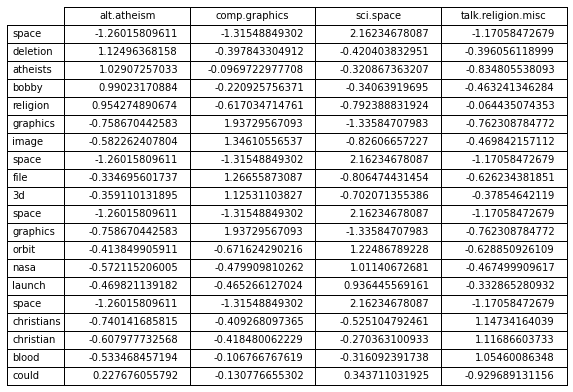

Strength of each keyword in the class/label


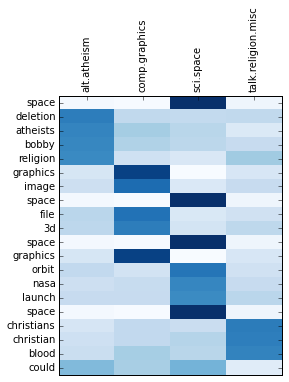

________________________________________________________________________________
size of the vocabulary = 194891
shape of training/feature vector = (2034, 194891)
shape of model weights vector = (4L, 194891L)
taking absolute value of the coefficients as both positive and negative values have an impact
________________________________________________________________________________
Table 4.2 - Top 5 features with the largest weights for each label - bigram words
________________________________________________________________________________


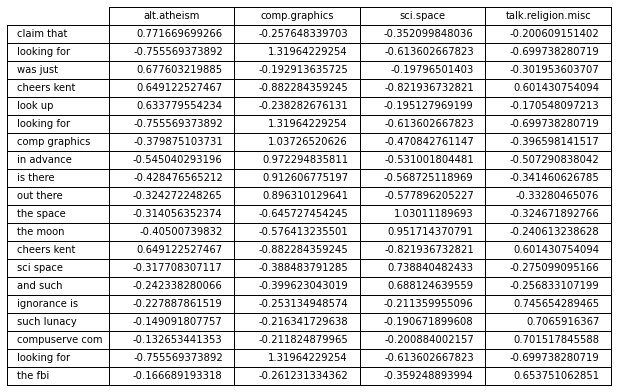

Strength of each keyword in the class/label


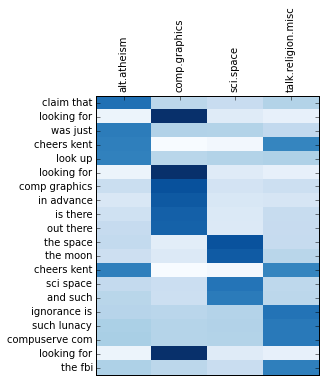

________________________________________________________________________________


In [26]:
def P4():
### STUDENT START ###
    # plot table function to display results
    def plot_table(cellval, rowlbl, collbl):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.axis('off')
        plt_table = ax.table(
            cellText=cellval,
            rowLabels=rowlbl,
            colLabels=collbl,
            loc='center') 
        plt_table.scale(1.5, 1.5)
        plt.show() 

        print "Strength of each keyword in the class/label"
        
        fig, ax = plt.subplots()
        fig.set_size_inches(4,5)
        ax.pcolor(cellval, cmap=plt.cm.Blues)

        ax.set_yticks(np.arange(len(rowlbl)) + 0.5, minor=False)
        ax.set_yticklabels(rowlbl)
        ax.invert_yaxis()

        ax.set_xticks(np.arange(len(collbl)) + .5, minor=False)
        ax.xaxis.tick_top()
        ax.set_xticklabels(newsgroups_train.target_names)
        plt.xticks(rotation = 90)

        plt.show()

    def top_N_features(n, N):
        # countvectorizer tokenizes and count the word occurrences of text documents. 
        count_vectorizer = CountVectorizer(ngram_range = (n,n))
        # feature extraction by turning raw training text to feature vectors
        train_x = count_vectorizer.fit_transform(train_data)

        print "size of the vocabulary = %d" % ( len(count_vectorizer.vocabulary_) )
        print "shape of training/feature vector = %s" % ( str(train_x.shape) )

        lgr = LogisticRegression(penalty='l2')
        lgr.fit(train_x, train_labels)
        num_labels = lgr.coef_.shape[0]
        print "shape of model weights vector = %s" % ( str(lgr.coef_.shape) )

        print "taking absolute value of the coefficients as both positive and negative values have an impact"
        coef = np.array(np.absolute(lgr.coef_))
        top_indices = np.argsort(-coef)[:, :N].flatten()
        top_values = np.take(lgr.coef_, top_indices, axis=1).T
        top_rownames = np.take(np.array(count_vectorizer.get_feature_names()), top_indices, axis=0) 
        top_colnames = np.take(newsgroups_train.target_names, range(num_labels), axis=0) 

        print "_" * 80
        if n == 1:
            print "Table 4.1 - Top %d features with the largest weights for each label - unigram words" % ( N )
        else:
            print "Table 4.2 - Top %d features with the largest weights for each label - bigram words" % ( N )
        print "_" * 80
        plot_table(top_values, top_rownames, top_colnames)
        print "_" * 80

    top_N_features(1, 5)
    top_N_features(2, 5)
    
### STUDENT END ###
P4()

**ANSWER:**

Using the bigram feature extraction commonly used bigram words such as "in this", "in there", "out there", "in advance", and "looking for" carry more weights.

**(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?**

**For reference, I was able to improve dev F1 by 2 points.**

In [27]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
### STUDENT START ###
    # stop words from https://code.google.com/p/metric-learning/
    stop_words = ['i', 'a', 'about', 'an', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'how', \
                  'in', 'is', 'it', 'of', 'on', 'or', 'that', 'the', 'this', 'to', 'was', 'what', \
                  'when', 'where', 'who', 'will', 'with', 'but', 'he', 'she', 'they', 'them', 'you', 'we', 'us']
    
    # length 1, 2, 3, 4 and 5 suffixes from http://www.nltk.org/_modules/nltk/stem/isri.html
    suffixes = ['y',  's',  'al',  'ed',  'en',  'er',  'es',  'ic',  'ly',  'ty',  'est',  'ful',  'ial',  \
                'ies',  'ion',  'ity',  'ive',  'ous',  'able',  'eous',  'ible',  'ious',  'less',  'ment',  
                'ness',  'tion',  'ing',  'ation',  'ative',  'ition',  'itive']

    # length 1, 2, 3, 4 and 5 prefixes from http://www.nltk.org/_modules/nltk/stem/isri.html
    prefixes = ['in', 'im', 'il', 'ir', 're', 'un', 'de', 'en', 'em', 'dis', 'mid', 'mis', 'non', 'pre', 'sub', \
                'anti', 'fore', 'over', 'semi', 'under' 'inter', 'super', 'trans']
    
    # convert string to lower case
    s = s.lower().strip()

    # exclude words with length <= 3 chars, shorten long words to 20 chars and remove stop words
    s = " ".join([word[:20] for word in s.split() if word.strip() not in stop_words and len(word.strip()) >= 3])
    
    # remove punctuations and special characters
    s = re.sub(r'[^a-zA-z0-9\_\s\?]', '', s)
    
    # shrink multiple spaces into single
    s = re.sub(r'\s+', ' ', s);
    
    # replace sequence of digits with 0
    s = re.sub(r'\d+', '0', s)
    
    # remove prefixes
    regex_prefix = "|".join([prefix for prefix in prefixes])
    regex_prefix = "\\b(" + regex_prefix + ")"
    s = re.sub(regex_prefix, '', s)
    
    # remove suffixes
    regex_suffix = "|".join([suffix for suffix in suffixes])
    regex_suffix = "(" + regex_suffix + ")\\b"
    s = re.sub(regex_suffix, '', s)
    
    # remove plurals
    #if len(s) <= 2:
    #    return s

    #if s[-1] == 's':
    #    if s.endswith("sses"):
    #        s = s[:-2]
    #    elif s.endswith("ies"):
    #        if len(s) == 4:
    #            s = s[:-1]
    #        else:
    #            s = s[:-2]
    #    elif s[-2] != 's':
    #        s = s[:-1]

    return s

### STUDENT END ###

def P5():
### STUDENT START ###
    print "_" * 80
    # countvectorizer tokenizes and count the word occurrences of text documents with empty pre-processor
    count_vectorizer = CountVectorizer(preprocessor=empty_preprocessor)
    # feature extraction by turning raw training text to feature vectors
    train_x = count_vectorizer.fit_transform(train_data)
    # turn raw dev data to feature vectors using training vocabulary
    dev_x = count_vectorizer.transform(dev_data)

    vocab_sz_empty_pp = len(count_vectorizer.vocabulary_)
    print "size of the vocabulary with empty pre-processor = %d" % ( vocab_sz_empty_pp )

    # run logistric regression
    lgr = LogisticRegression(penalty="l2", C=0.1)
    lgr.fit(train_x, train_labels)
    print "shape of model weights vector = %s" % ( str(lgr.coef_.shape) )
    
    score_empty_pp = metrics.f1_score(dev_labels, lgr.predict(dev_x))
    print "predicted score with empty pre-processor = %f" % ( score_empty_pp )

    print "_" * 80
    # countvectorizer tokenizes and count the word occurrences of text documents with better pre-processor
    count_vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    # feature extraction by turning raw training text to feature vectors
    train_x = count_vectorizer.fit_transform(train_data)
    # turn raw dev data to feature vectors using training vocabulary
    dev_x = count_vectorizer.transform(dev_data)
    
    vocab_sz_better_pp = len(count_vectorizer.vocabulary_)
    print "size of the vocabulary with better pre-processor = %d" % ( vocab_sz_better_pp )
    
    # run logistric regression
    lgr = LogisticRegression(penalty="l2", C=0.1)
    lgr.fit(train_x, train_labels)
    print "shape of model weights vector = %s" % ( str(lgr.coef_.shape) )

    score_better_pp = metrics.f1_score(dev_labels, lgr.predict(dev_x))
    print "predicted score with better pre-processor = %f" % ( score_better_pp )

    print "_" * 80
    print "F1 score improvement with better pre-processor = %f" % (score_better_pp - score_empty_pp)
    print "F1 score improvement with better pre-processor (%%) = %f" % ( ((score_better_pp - score_empty_pp) / score_empty_pp) * 100 )

    print "Dictionary size with better pre-processor reduced by (%%) = %f" % ( ((vocab_sz_empty_pp - vocab_sz_better_pp) / (1.0 * vocab_sz_empty_pp)) * 100 )

### STUDENT END ###
P5()

________________________________________________________________________________
size of the vocabulary with empty pre-processor = 33291
shape of model weights vector = (4L, 33291L)
predicted score with empty pre-processor = 0.701397
________________________________________________________________________________
size of the vocabulary with better pre-processor = 20411
shape of model weights vector = (4L, 20411L)
predicted score with better pre-processor = 0.733823
________________________________________________________________________________
F1 score improvement with better pre-processor = 0.032425
F1 score improvement with better pre-processor (%) = 4.622934
Dictionary size with better pre-processor reduced by (%) = 38.689135


**(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.**

**Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".**

**Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.**

**Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).**

________________________________________________________________________________
logistic regression model using a L1 penalty
shape of model weights vector = (4L, 26879L)
number of learned non-zero weights with L1 penality = 1815
number of learned zero weights with L1 penality = 105701
vocabulary size with L1 penality = 1080
--------------------------------------------------------------------------------
logistic regression model using a L2 penalty
shape of model weights vector = (4L, 26879L)
number of learned non-zero weights with L2 penality = 107516
number of learned zero weights with L2 penality = 0
vocabulary size with L2 penality = 26879


------------------------------------------------------------
         C | Vocab Size | F-score of retrained model
------------------------------------------------------------
     0.001 |          2 | 0.322508590629
   0.00115 |          3 | 0.334445501149
   0.00132 |          2 | 0.322508590629
   0.00152 |          3 | 0.352029369245
   0.00

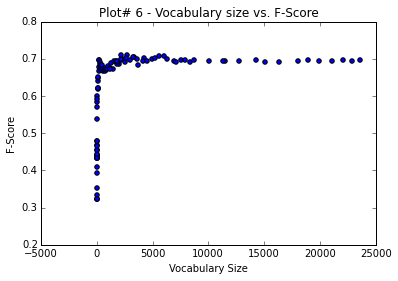

________________________________________________________________________________


In [30]:
def P6():
    # WARNING: due to longer range this functions runs ~15 min

    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    ### STUDENT START ###
    # countvectorizer tokenizes and count the word occurrences of text documents
    count_vectorizer = CountVectorizer()
    # feature extraction by turning raw training text to feature vectors
    train_x = count_vectorizer.fit_transform(train_data)
    # turn raw dev data to feature vectors using training vocabulary
    dev_x = count_vectorizer.transform(dev_data)

    print "_" * 80
    # logistic regression model using a "l1" penalty
    print "logistic regression model using a L1 penalty"
    lgr_l1 = LogisticRegression(penalty="l1", tol=0.01)
    lgr_l1.fit(train_x, train_labels)
    lgr_l1_nnz = lgr_l1.coef_.nonzero()[1]
    vocab_size_l1 = train_x[:, np.unique(lgr_l1.coef_.nonzero()[1])].shape[1]

    print "shape of model weights vector = %s" % ( str(lgr_l1.coef_.shape) )
    print "number of learned non-zero weights with L1 penality = %d" %( len(lgr_l1_nnz) )
    print "number of learned zero weights with L1 penality = %d" % ( lgr_l1.coef_[ (lgr_l1.coef_ == 0) ].shape )
    print "vocabulary size with L1 penality = %d" %( vocab_size_l1 )
    
    lgr_l2 = LogisticRegression(penalty="l2", tol=0.01)
    lgr_l2.fit(train_x, train_labels)
    lgr_l2_nnz = lgr_l2.coef_.nonzero()[1]
    vocab_size_l2 = train_x[:, np.unique(lgr_l2.coef_.nonzero()[1])].shape[1]

    print "-" * 80
    print "logistic regression model using a L2 penalty"
    print "shape of model weights vector = %s" % ( str(lgr_l2.coef_.shape) )
    print "number of learned non-zero weights with L2 penality = %d" %( len(lgr_l2_nnz) )
    print "number of learned zero weights with L2 penality = %d" % ( lgr_l2.coef_[ (lgr_l2.coef_ == 0) ].shape )
    print "vocabulary size with L2 penality = %d" %( vocab_size_l2 )

    vocab_size = []
    f1_score = []
    
    # define C range 
    # NOTE: due to longer range this functions runs ~15 min
    c_range = np.logspace(-3., 3., 100)
    
    print "\n"
    print "-" * 60
    print "%10s | %10s | %s" % ( "C", "Vocab Size", "F-score of retrained model")
    print "-" * 60
    for c in c_range:
        lgr = LogisticRegression(penalty='l1', tol=0.01, C=c)
        lgr.fit(train_x, train_labels)
        
        pruned_train_x = train_x[:, np.unique(lgr.coef_.nonzero()[1])]
        pruned_dev_x = dev_x[:, np.unique(lgr.coef_.nonzero()[1])]

        vocab_size.append(pruned_train_x.shape[1])
        
        lgr = LogisticRegression(penalty='l2')
        lgr.fit(pruned_train_x, train_labels)

        dev_y = [lgr.predict(v)[0] for v in pruned_dev_x]
        score = metrics.f1_score(dev_labels, dev_y, average='weighted')
        
        f1_score.append(score)

        print '%10s | %10s | %s' % (str(round(c, 5)), str(pruned_train_x.shape[1]), str(score))
    print "-" * 60
    print "\n"

    print "Plot showing accuracy of the re-trained model vs. the vocabulary size with pruning unused features by adjusting the C parameter"
    fig, ax = plt.subplots(1, 1)
    ax.set_title("Plot# 6 - Vocabulary size vs. F-Score")
    ax.set_ylabel("F-Score")
    ax.set_xlabel("Vocabulary Size")
    ax.scatter(vocab_size, f1_score)
    plt.show()
    fig.tight_layout()

    print "_" * 80
    
    ### STUDENT END ###
P6()

**(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.**

**Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:
maximum predicted probability / predicted probability of the correct label**

**What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.**

In [31]:
def P7():
### STUDENT START ###
    # TfidfVectorizer converts raw documents to a matrix of TF-IDF features
    train_vectorizer = TfidfVectorizer()
    # feature extraction by turning raw training text to feature vectors
    train_x = train_vectorizer.fit_transform(train_data)
    # turn raw dev data to feature vectors using training vocabulary
    dev_x = train_vectorizer.transform(dev_data)
    
    print "_" * 80
    print "shape of training feature vector = %s" % ( str(train_x.shape) )
    print "shape of dev feature vector = %s" % ( str(dev_x.shape) )
    
    # run logistric regression
    lgr = LogisticRegression(penalty="l2", C=100)
    lgr.fit(train_x, train_labels)
    
    # predict probability estimates
    pred_prob = lgr.predict_proba(dev_x)
    print "shape of probability estimates = %s" % ( str(pred_prob.shape) )
    
    # find max probability estimates
    max_prob = np.amax(pred_prob, axis=1)
    print "shape of max probability estimates = %s" % ( str(max_prob.shape) )
    
    # find predicted probability of the correct labels
    indices = np.arange(len(dev_labels))
    corr_prob = pred_prob[indices, dev_labels]
    
    # calculate r-ratio
    r_ratio = max_prob/corr_prob
    
    # identify top 3 documents where the ratio R is largest
    max_r_ratio = r_ratio.argsort()[-3:][::-1]

    print "top 3 R-ratios: %s" % ( r_ratio[max_r_ratio] )

    # print document text
    # start and end to format header as bold and red
    start = "\x1b[1;31m"
    end = "\x1b[0m"
    
    # show document text
    print "_" * 80
    for i in max_r_ratio:
        # print label name from newsgroups_train.target_names and corresponding document text
        print(start + 
              "Label = '" + newsgroups_train.target_names[dev_labels[i]] + "' :" + 
              end)
        print dev_data[i]       
        print "_" * 80   # formatting line

## STUDENT END ###
P7()

________________________________________________________________________________
shape of training feature vector = (2034, 26879)
shape of dev feature vector = (676, 26879)
shape of probability estimates = (676L, 4L)
shape of max probability estimates = (676L,)
top 3 R-ratios: [ 929.35928821  325.00440518  287.30686109]
________________________________________________________________________________
Label = 'talk.religion.misc' :
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, 

**ANSWER:**

**TF-IDF vs CountVectorizer**

*Count Vectorizer* tokenizes the strings and gives a vector for each document with each feature corresponding to the number of times a token is found in the corresponding document. Most of the entries in all of the vectors will be zero, since only the entries which correspond to the tokens found in that specific document will have positive values, but the vector length is same as the total number of tokens for the whole corpus. The total feature space is sparse matrix.

*TF-IDF vectorizer* converts raw documents to feature vectors based on the document frequency for the corpus and determines tf-idf values. TF-IDF values determine how important is a word in a document.

Both the vectorizers have same vocabulary size.

**What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.**

Reading the literature about the TF-IDF algorithm and based on prior exercises in the courses there are two mistakes/scenarios overlooked by TF-IDF

(i) IDF (inverse document frequency) algorithm assumes importance of each term is inversely proportional to the number of documents that the term occurs. However, it is possible that the term which occurs widely in the corpus but intensively appears in a few documents much probably represents the topic of a document category and is significant for text classifying. IDF overlooks this scenario and assigns a low term weight to such terms. 

(ii) IDF assigns high term weight to empty terms and function terms, including conjunctive, preposition, some adverbs. This leads to inaccurate weight assignments to such terms. This can be corrected to a great extent by stop words, stemming,  Lemmatisation etc.

**(8) EXTRA CREDIT**

**Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.**

In [33]:
def P8():
    print "%7s | %40s | %20s | %10s" % ( "step  #", "improvement performed", "score", "improvement" )
    print "-" * 90
    
    # baseline score empty pre-processor
    lr_pipe = Pipeline(
        [
            ('tfidf_vect', TfidfVectorizer()),
            ('clf', LogisticRegression(penalty="l2", C=100)),
        ])
    lr_pipe.fit(train_data, train_labels)
    score1 =  metrics.f1_score(dev_labels, lr_pipe.predict(dev_data), average='weighted')
    print "%6s | %40s | %20s | %10s %%" % ( "step  1", "baseline score", str(score1), "0" )

    # removed stop words
    lr_pipe = Pipeline(
        [
            ('tfidf_vect', TfidfVectorizer(stop_words='english')),
            ('clf', LogisticRegression(penalty="l2", C=100)),
        ])
    lr_pipe.fit(train_data, train_labels)
    score2 =  metrics.f1_score(dev_labels, lr_pipe.predict(dev_data), average='weighted')
    improvement = round(((score2 - score1) / score1) * 100, 2)
    print "%6s | %40s | %20s | %10s %%" % ( "step  2", "stop words", str(score2), str(improvement) )

    # removed accents
    lr_pipe = Pipeline(
        [
            ('tfidf_vect', TfidfVectorizer(stop_words='english', strip_accents='unicode')),
            ('clf', LogisticRegression(penalty="l2", C=100)),
        ])
    lr_pipe.fit(train_data, train_labels)
    score2 =  metrics.f1_score(dev_labels, lr_pipe.predict(dev_data), average='weighted')
    improvement = round(((score2 - score1) / score1) * 100, 2)
    print "%6s | %40s | %20s | %10s %%" % ( "step  3", "remove accents", str(score2), str(improvement) )

    # set minimum df
    lr_pipe = Pipeline(
        [
            ('tfidf_vect', TfidfVectorizer(stop_words='english', strip_accents='unicode', min_df = 1)),
            ('clf', LogisticRegression(penalty="l2", C=10))
        ])
    lr_pipe.fit(train_data, train_labels)
    score2 =  metrics.f1_score(dev_labels, lr_pipe.predict(dev_data), average='weighted')
    improvement = round(((score2 - score1) / score1) * 100, 2)
    print "%6s | %40s | %20s | %10s %%" % ( "step  4", "set minimum df", str(score2), str(improvement) )

    # chain feature extraction
    lr_pipe = Pipeline([
            ('tfidf_vect', TfidfVectorizer(stop_words='english', strip_accents='unicode', min_df = 1)),
            ('tfidf_trn', TfidfTransformer()),
            ('clf', LogisticRegression(penalty="l2", C=100))
        ])
    lr_pipe.fit(train_data, train_labels)
    score2 =  metrics.f1_score(dev_labels, lr_pipe.predict(dev_data), average='weighted')
    improvement = round(((score2 - score1) / score1) * 100, 2)
    print "%6s | %40s | %20s | %10s %%" % ( "step  5", "chain features extractors", str(score2), str(improvement) )

    
P8()

step  # |                    improvement performed |                score | improvement
------------------------------------------------------------------------------------------
step  1 |                           baseline score |       0.759766242785 |          0 %
step  2 |                               stop words |       0.778438538753 |       2.46 %
step  3 |                           remove accents |       0.778438538753 |       2.46 %
step  4 |                           set minimum df |       0.773911243019 |       1.86 %
step  5 |                chain features extractors |       0.793672408296 |       4.46 %
